# Intraday Trading Strategy (GARCH Model)

- Using simulated daily and intraday 5-min data
- Define a function to fit GARCH model onto the data and predict volatility for the following day in a rolling window
- Calculate prediction premium and form a daily signal
- Merge with intraday data and calculate intraday indicators to form an intraday signal
- Generate the position entry and hold until the end of day
- Calculate returns

## 1. Load Simulated Daily and Simulated 5-minute data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import pandas_ta
import pandas as pd
import numpy as np
from arch import arch_model
import os

folder = 'E:/Downloads'

dailydf = pd.read_csv(os.path.join(folder, 'simulated_daily_data.csv'))

dailydf = dailydf.drop('Unnamed: 7', axis=1)

dailydf['Date'] = pd.to_datetime(dailydf['Date'])

dailydf = dailydf.set_index('Date')

intraday5mindf = pd.read_csv(os.path.join(folder, 'simulated_5min_data.csv'))

intraday5mindf = intraday5mindf.drop('Unnamed: 6', axis=1)

intraday5mindf['datetime'] = pd.to_datetime(intraday5mindf['datetime'])

intraday5mindf = intraday5mindf.set_index('datetime')

intraday5mindf['date'] = pd.to_datetime(intraday5mindf.index.date)

cutoff_date = pd.to_datetime('2023-02-28')

intraday5mindf = intraday5mindf[intraday5mindf.index <= cutoff_date]

intraday5mindf

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-02-27 23:40:00,5851.8475,5851.5100,5854.0450,5852.9025,5,2023-02-27
2023-02-27 23:45:00,5852.9025,5846.8100,5857.0025,5857.0025,20,2023-02-27
2023-02-27 23:50:00,5857.2475,5847.8725,5859.7600,5857.3500,38,2023-02-27


## 2. Define function to fit GARCH model and predict the following day's volatility in a rolling window

- Calculate 6 month rolling variance
- Fit a GARCH model to predict next day variance in the 6-month rolling window

In [2]:
dailydf['log ret'] = np.log(dailydf['Adj Close']).diff()

dailydf['variance'] = dailydf['log ret'].rolling(180).var()

dailydf = dailydf['2020':]

def predictVolatility(x):
    
    bestModel = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    
    forecastedVariance = bestModel.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return forecastedVariance

dailydf['predictions'] = dailydf['log ret'].rolling(180).apply(lambda x: predictVolatility(x))

dailydf = dailydf.dropna()

dailydf

E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00243. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which ma

2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002347. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2020-09-13 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-20 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whic

2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-03 00:00:00
2020-10-04 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007936. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-10-11 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00
2020-10-17 00:00:00
2020-10-18 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-10-21 00:00:00
2020-10-22 00:00:00
2020-10-23 00:00:00
2020-10-24 00:00:00
2020-10-25 00:00:00
2020-10-26 00:00:00
2020-10-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-10-31 00:00:00
2020-11-01 00:00:00
2020-11-02 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006535. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-11-03 00:00:00
2020-11-04 00:00:00
2020-11-05 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006751. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-11-06 00:00:00
2020-11-07 00:00:00
2020-11-08 00:00:00
2020-11-09 00:00:00
2020-11-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-14 00:00:00
2020-11-15 00:00:00
2020-11-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2020-11-17 00:00:00
2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-21 00:00:00
2020-11-22 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006234. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-11-23 00:00:00
2020-11-24 00:00:00
2020-11-25 00:00:00
2020-11-26 00:00:00
2020-11-27 00:00:00
2020-11-28 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-11-29 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00
2020-12-02 00:00:00
2020-12-03 00:00:00
2020-12-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006518. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-12-05 00:00:00
2020-12-06 00:00:00
2020-12-07 00:00:00
2020-12-08 00:00:00
2020-12-09 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006651. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-12-10 00:00:00
2020-12-11 00:00:00
2020-12-12 00:00:00
2020-12-13 00:00:00
2020-12-14 00:00:00
2020-12-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006602. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-12-16 00:00:00
2020-12-17 00:00:00
2020-12-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2020-12-19 00:00:00
2020-12-20 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00
2020-12-23 00:00:00
2020-12-24 00:00:00
2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is

2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00
2021-01-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008839. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling i

2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001008. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whic

2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001044. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which ma

2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001388. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001524. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-03-01 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00
2021-03-07 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001489. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00
2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001531. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1

2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1

2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001584. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001584. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001582. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001601. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001717. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001734. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001739. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00174. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002203. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-05 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-06-11 00:00:00
2021-06-12 00:00:00
2021-06-13 00:00:00
2021-06-14 00:00:00
2021-06-15 00:00:00
2021-06-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-06-17 00:00:00
2021-06-18 00:00:00
2021-06-19 00:00:00
2021-06-20 00:00:00
2021-06-21 00:00:00
2021-06-22 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002288. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-06-23 00:00:00
2021-06-24 00:00:00
2021-06-25 00:00:00
2021-06-26 00:00:00
2021-06-27 00:00:00
2021-06-28 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002337. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002384. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-06-29 00:00:00
2021-06-30 00:00:00
2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-03 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-07-04 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-07-11 00:00:00
2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00
2021-07-18 00:00:00
2021-07-19 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-24 00:00:00
2021-07-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002071. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00
2021-07-29 00:00:00
2021-07-30 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-07-31 00:00:00
2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-07 00:00:00
2021-08-08 00:00:00
2021-08-09 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002045. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-08-10 00:00:00
2021-08-11 00:00:00
2021-08-12 00:00:00
2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001881. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001884. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00
2021-08-19 00:00:00
2021-08-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001856. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-08-21 00:00:00
2021-08-22 00:00:00
2021-08-23 00:00:00
2021-08-24 00:00:00
2021-08-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-28 00:00:00
2021-08-29 00:00:00
2021-08-30 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00
2021-09-03 00:00:00
2021-09-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001752. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001753. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-09-05 00:00:00
2021-09-06 00:00:00
2021-09-07 00:00:00
2021-09-08 00:00:00
2021-09-09 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-09-10 00:00:00
2021-09-11 00:00:00
2021-09-12 00:00:00
2021-09-13 00:00:00
2021-09-14 00:00:00
2021-09-15 00:00:00
2021-09-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-09-17 00:00:00
2021-09-18 00:00:00
2021-09-19 00:00:00
2021-09-20 00:00:00
2021-09-21 00:00:00
2021-09-22 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001758. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-09-23 00:00:00
2021-09-24 00:00:00
2021-09-25 00:00:00
2021-09-26 00:00:00
2021-09-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-09-28 00:00:00
2021-09-29 00:00:00
2021-09-30 00:00:00
2021-10-01 00:00:00
2021-10-02 00:00:00
2021-10-03 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001835. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-10-04 00:00:00
2021-10-05 00:00:00
2021-10-06 00:00:00
2021-10-07 00:00:00
2021-10-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001893. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-10-09 00:00:00
2021-10-10 00:00:00
2021-10-11 00:00:00
2021-10-12 00:00:00
2021-10-13 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001905. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001918. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-10-14 00:00:00
2021-10-15 00:00:00
2021-10-16 00:00:00
2021-10-17 00:00:00
2021-10-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001916. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001916. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00
2021-10-22 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-10-23 00:00:00
2021-10-24 00:00:00
2021-10-25 00:00:00
2021-10-26 00:00:00
2021-10-27 00:00:00
2021-10-28 00:00:00
2021-10-29 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-10-30 00:00:00
2021-10-31 00:00:00
2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00
2021-11-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001838. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001808. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001517. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2021-11-28 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-11 00:00:00
2021-12-12 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001326. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001332. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-18 00:00:00
2021-12-19 00:00:00
2021-12-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-24 00:00:00
2021-12-25 00:00:00
2021-12-26 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00
2021-12-30 00:00:00
2021-12-31 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001142. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
2022-02-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-02-16 00:00:00
2022-02-17 00:00:00
2022-02-18 00:00:00
2022-02-19 00:00:00
2022-02-20 00:00:00
2022-02-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which ma

2022-02-22 00:00:00
2022-02-23 00:00:00
2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-02-28 00:00:00
2022-03-01 00:00:00
2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-05 00:00:00
2022-03-06 00:00:00
2022-03-07 00:00:00
2022-03-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-03-09 00:00:00
2022-03-10 00:00:00
2022-03-11 00:00:00
2022-03-12 00:00:00
2022-03-13 00:00:00
2022-03-14 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001265. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-03-15 00:00:00
2022-03-16 00:00:00
2022-03-17 00:00:00
2022-03-18 00:00:00
2022-03-19 00:00:00
2022-03-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00127. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-03-21 00:00:00
2022-03-22 00:00:00
2022-03-23 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-03-24 00:00:00
2022-03-25 00:00:00
2022-03-26 00:00:00
2022-03-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-03-28 00:00:00
2022-03-29 00:00:00
2022-03-30 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-04-02 00:00:00
2022-04-03 00:00:00
2022-04-04 00:00:00
2022-04-05 00:00:00
2022-04-06 00:00:00
2022-04-07 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001108. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-04-08 00:00:00
2022-04-09 00:00:00
2022-04-10 00:00:00
2022-04-11 00:00:00
2022-04-12 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001079. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-04-13 00:00:00
2022-04-14 00:00:00
2022-04-15 00:00:00
2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00
2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-04-29 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-04-30 00:00:00
2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-05-27 00:00:00
2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00
2022-06-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned c

2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-06-15 00:00:00
2022-06-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001476. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-08-04 00:00:00
2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-08-09 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-12 00:00:00
2022-08-13 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00
2022-08-18 00:00:00
2022-08-19 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-08-20 00:00:00
2022-08-21 00:00:00
2022-08-22 00:00:00
2022-08-23 00:00:00
2022-08-24 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001375. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-08-25 00:00:00
2022-08-26 00:00:00
2022-08-27 00:00:00
2022-08-28 00:00:00
2022-08-29 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-08-30 00:00:00
2022-08-31 00:00:00
2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00
2022-09-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-09-05 00:00:00
2022-09-06 00:00:00
2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00
2022-09-13 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001239. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-09-14 00:00:00
2022-09-15 00:00:00
2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-09-19 00:00:00
2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00
2022-09-23 00:00:00
2022-09-24 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-09-30 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00
2022-10-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001246. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which m

2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001284. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001268. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-12-02 00:00:00
2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which 

2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whic

2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008616. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00
2023-01-23 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008175. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-28 00:00:00
2023-01-29 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-04 00:00:00
2023-02-05 00:00:00
2023-02-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008045. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008066. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-02-12 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-18 00:00:00
2023-02-19 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007979. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-02-26 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-03-05 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-03-11 00:00:00
2023-03-12 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00
2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007593. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-03-27 00:00:00
2023-03-28 00:00:00
2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00
2023-04-01 00:00:00
2023-04-02 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00
2023-04-09 00:00:00
2023-04-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00
2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00
2023-04-19 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008102. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-04-20 00:00:00
2023-04-21 00:00:00
2023-04-22 00:00:00
2023-04-23 00:00:00
2023-04-24 00:00:00
2023-04-25 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000844. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returne

2023-04-26 00:00:00
2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00
2023-04-30 00:00:00
2023-05-01 00:00:00
2023-05-02 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000837. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00
2023-05-08 00:00:00
2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000838. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-05-12 00:00:00
2023-05-13 00:00:00
2023-05-14 00:00:00
2023-05-15 00:00:00
2023-05-16 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-05-17 00:00:00
2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00
2023-05-21 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005815. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005771. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-05-22 00:00:00
2023-05-23 00:00:00
2023-05-24 00:00:00
2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-05-28 00:00:00
2023-05-29 00:00:00
2023-05-30 00:00:00
2023-05-31 00:00:00
2023-06-01 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005727. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-06-02 00:00:00
2023-06-03 00:00:00
2023-06-04 00:00:00
2023-06-05 00:00:00
2023-06-06 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00
2023-06-10 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-06-11 00:00:00
2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00
2023-06-15 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-06-16 00:00:00
2023-06-17 00:00:00
2023-06-18 00:00:00
2023-06-19 00:00:00
2023-06-20 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005992. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-06-21 00:00:00
2023-06-22 00:00:00
2023-06-23 00:00:00
2023-06-24 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006318. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-06-25 00:00:00
2023-06-26 00:00:00
2023-06-27 00:00:00
2023-06-28 00:00:00
2023-06-29 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-06-30 00:00:00
2023-07-01 00:00:00
2023-07-02 00:00:00
2023-07-03 00:00:00
2023-07-04 00:00:00
2023-07-05 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-07-06 00:00:00
2023-07-07 00:00:00
2023-07-08 00:00:00
2023-07-09 00:00:00
2023-07-10 00:00:00
2023-07-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-07-12 00:00:00
2023-07-13 00:00:00
2023-07-14 00:00:00
2023-07-15 00:00:00
2023-07-16 00:00:00
2023-07-17 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000605. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-07-18 00:00:00
2023-07-19 00:00:00
2023-07-20 00:00:00
2023-07-21 00:00:00
2023-07-22 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005807. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-07-23 00:00:00
2023-07-24 00:00:00
2023-07-25 00:00:00
2023-07-26 00:00:00
2023-07-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-07-28 00:00:00
2023-07-29 00:00:00
2023-07-30 00:00:00
2023-07-31 00:00:00
2023-08-01 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005687. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-08-02 00:00:00
2023-08-03 00:00:00
2023-08-04 00:00:00
2023-08-05 00:00:00
2023-08-06 00:00:00
2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-08-10 00:00:00
2023-08-11 00:00:00
2023-08-12 00:00:00
2023-08-13 00:00:00
2023-08-14 00:00:00
2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00
2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00
2023-08-25 00:00:00
2023-08-26 00:00:00
2023-08-27 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-08-28 00:00:00
2023-08-29 00:00:00
2023-08-30 00:00:00
2023-08-31 00:00:00
2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005306. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, whi

2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00


E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003913. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
E:\Anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, wh

,Open,High,Low,Close,Adj Close,Volume,log ret,variance,predictions
Date,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


## 3. Calculate prediction premium and form a daily signal from it

- Calculate prediction premium. 
- Calculate 6-month rolling std. dev. of prediction premium.
- Create daily signal

In [3]:
dailydf['predictionPremium'] = (dailydf['predictions']-dailydf['variance'])/dailydf['variance']

dailydf['premium std'] = dailydf['predictionPremium'].rolling(180).std()

dailydf['daily signal'] = dailydf.apply(lambda x: 1 if (x['predictionPremium']>x['premium std'])
                                         else (-1 if (x['predictionPremium']<x['premium std']*-1) else np.nan),
                                         axis=1)

dailydf['daily signal'] = dailydf['daily signal'].shift()

dailydf

,Open,High,Low,Close,Adj Close,Volume,log ret,variance,predictions,predictionPremium,premium std,daily signal
Date,,,,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728,-0.705556,NaN,NaN
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736678,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644670,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748302,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.544319,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.541657,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.540672,NaN


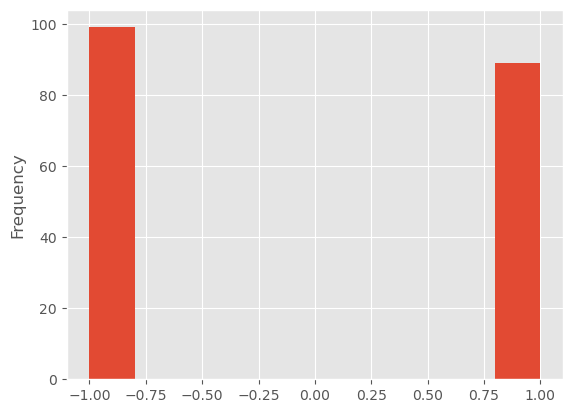

In [4]:
plt.style.use('ggplot')

dailydf['daily signal'].plot(kind='hist')

plt.show()

## 4. Calculate intraday indicators to form an intraday signal

In [5]:
df = intraday5mindf.reset_index()\
                            .merge(dailydf[['daily signal']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

df['rsi'] = pandas_ta.rsi(close=df['close'],
                                length=20)

df['lband'] = pandas_ta.bbands(close=df['close'],
                                     length=20).iloc[:,0]

df['uband'] = pandas_ta.bbands(close=df['close'],
                                     length=20).iloc[:,2]

df['intraday signal'] = df.apply(lambda x: 1 if (x['rsi']>70)&(x['close']>x['uband']) else (-1 if (x['rsi']<30)&
                                                (x['close']<x['lband']) else np.nan), axis=1)

df['return'] = np.log(df['close']).diff()

df

,open,low,high,close,volume,daily signal,rsi,lband,uband,intraday signal,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27 23:40:00,5851.8475,5851.5100,5854.0450,5852.9025,5,NaN,44.302482,5847.776736,5877.873764,NaN,0.000180
2023-02-27 23:45:00,5852.9025,5846.8100,5857.0025,5857.0025,20,NaN,47.658173,5847.201023,5877.619977,NaN,0.000700
2023-02-27 23:50:00,5857.2475,5847.8725,5859.7600,5857.3500,38,NaN,47.938016,5847.140806,5876.062444,NaN,0.000059


## 5. Generate entry position and calculate return by the end of the day.

In [6]:
df['return sign'] = df.apply(lambda x: -1 if (x['daily signal']==1)&(x['intraday signal']==1)
                                        else (1 if (x['daily signal']==-1)&(x['intraday signal']==-1) else np.nan),
                                        axis=1)

df['return sign'] = df.groupby(pd.Grouper(freq='D'))['return sign']\
                                  .transform(lambda x: x.ffill())

df['forward return'] = df['return'].shift(-1)

df['strategy return'] = df['forward return']*df['return sign']

dailyreturndf = df.groupby(pd.Grouper(freq='D'))['strategy return'].sum()

## 6. Calculate final returns

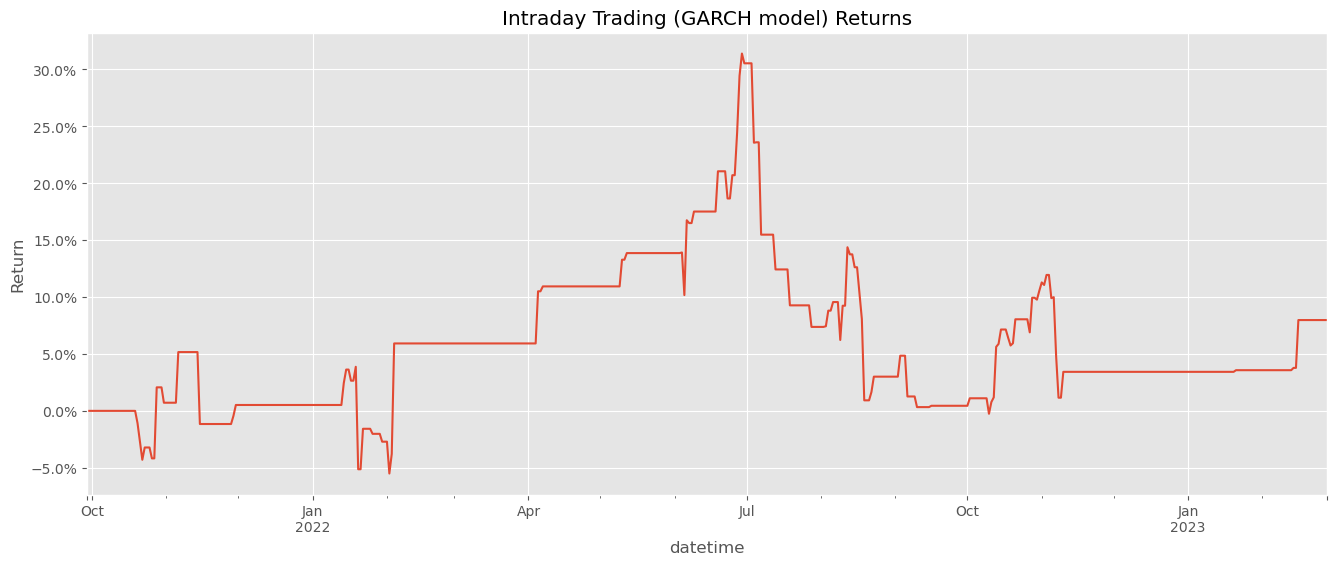

In [7]:
cumulativeReturn = np.exp(np.log1p(dailyreturndf).cumsum()).sub(1)

cumulativeReturn.plot(figsize=(16,6))

plt.title('Intraday Trading (GARCH model) Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            